# Import

In [60]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, ConvLSTM1D, Flatten
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import keras
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

# Get data

In [61]:
df = pd.read_csv('../backtest_tools/database/database/Binance/1h/AAVE-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
df = df.iloc[1:]
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df = df.astype(float)
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')

df['Close_filtered'] = savgol_filter(df['Close'].values, 25, 2,mode='nearest')

print(f"Total records : {len(df)} rows")
df.head()

Total records : 14269 rows


,Open,High,Low,Close,Volume,Timestamp,Close_filtered
Date,,,,,,,
2020-10-15 05:00:00,51.430,59.000,46.437,47.099,13042.026,1602730800,47.501871
2020-10-15 06:00:00,47.097,47.916,46.158,47.486,4565.137,1602734400,47.538019
2020-10-15 07:00:00,47.429,49.746,47.428,49.000,5618.395,1602738000,47.526094
2020-10-15 08:00:00,49.000,49.496,48.610,49.031,1977.936,1602741600,47.472154
2020-10-15 09:00:00,49.150,49.208,48.610,49.000,3338.552,1602745200,47.388616


# Trying to denoise.

## Normalize data

In [15]:
WINDOW = 100
INDEXING_WINDOW = 1

df['Close_filtered_norm'] = (df.Close_filtered-df.Close_filtered.mean())/df.Close_filtered.std()
df['Close_norm'] = (df.Close-df.Close.mean())/df.Close.std()

## Train and Test training

In [16]:
#df =  df.iloc[-5000:]

X = np.array([df.Close_norm.iloc[i:i+WINDOW].values.reshape(1,-1) for i in range(len(df)-WINDOW)])[:-INDEXING_WINDOW]
y = np.array([df.Close_filtered_norm.iloc[i:i+WINDOW].values.reshape(1,-1) for i in range(len(df)-WINDOW)])[INDEXING_WINDOW:]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

(39939, 1, 100)


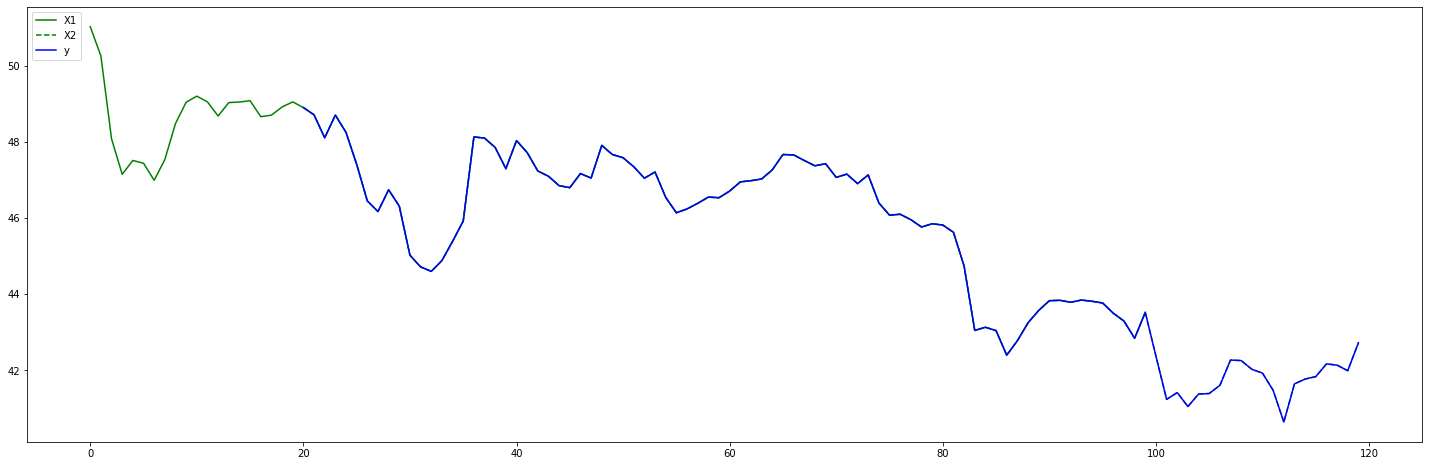

In [102]:
fig, ax_left = plt.subplots(1, figsize=(25,8))


ax_left.plot(list(range(len(X[0][0]))),X[0][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='X1')
ax_left.plot([i+INDEXING_WINDOW for i in range(len(X[INDEXING_WINDOW][0]))],X[INDEXING_WINDOW][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='X2', linestyle='--')
ax_left.plot([i+INDEXING_WINDOW for i in range(len(y[INDEXING_WINDOW][0]))],y[0][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='blue',label='y')
ax_left.legend(loc="upper left")
print(X_train.shape)

## Trying to denoise timeseries

### Only dense

In [42]:
input_window = Input(shape=(1,WINDOW))
encoded = Dense(10, activation='relu')(input_window)
inter_1 = Dense(30, activation='relu')(encoded)
decoded = Dense(WINDOW, activation='linear')(inter_1)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X, y,
                epochs=200,
                batch_size=1024,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stop])

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 100)]          0         
                                                                 
 dense_22 (Dense)            (None, 1, 10)             1010      
                                                                 
 dense_23 (Dense)            (None, 1, 30)             330       
                                                                 
 dense_24 (Dense)            (None, 1, 100)            3100      
                                                                 
Total params: 4,440
Trainable params: 4,440
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
47/47 [==============================] - 2s 22ms/step - loss: 0.6746 - val_loss: 0.0985
Epoch 2/200
47/47 [==============================] - 0s 11ms/step - loss: 0.1067 - val_l

### With LSTM

In [17]:
input_window = Input(shape=(1,WINDOW))
encoded = LSTM(4, kernel_initializer='he_uniform', return_sequences=True, name='encoder_1')(input_window)
encoded_2 = Dense(10, activation='relu',)(encoded)
norm_1 = BatchNormalization()(encoded_2)
inter_1 = Dense(30, activation='relu')(norm_1)
norm_2 = BatchNormalization()(inter_1)
decoded = Dense(WINDOW, activation='linear')(norm_2)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

history = autoencoder.fit(X, y,
                epochs=200,
                batch_size=1024,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stop])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 100)]          0         
                                                                 
 encoder_1 (LSTM)            (None, 1, 4)              1680      
                                                                 
 dense_6 (Dense)             (None, 1, 10)             50        
                                                                 
 batch_normalization_4 (Batc  (None, 1, 10)            40        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 1, 30)             330       
                                                                 
 batch_normalization_5 (Batc  (None, 1, 30)            120       
 hNormalization)                                           

In [18]:
predictions = autoencoder.predict(X)
print(len(X))
print(len(predictions))

57075
57075


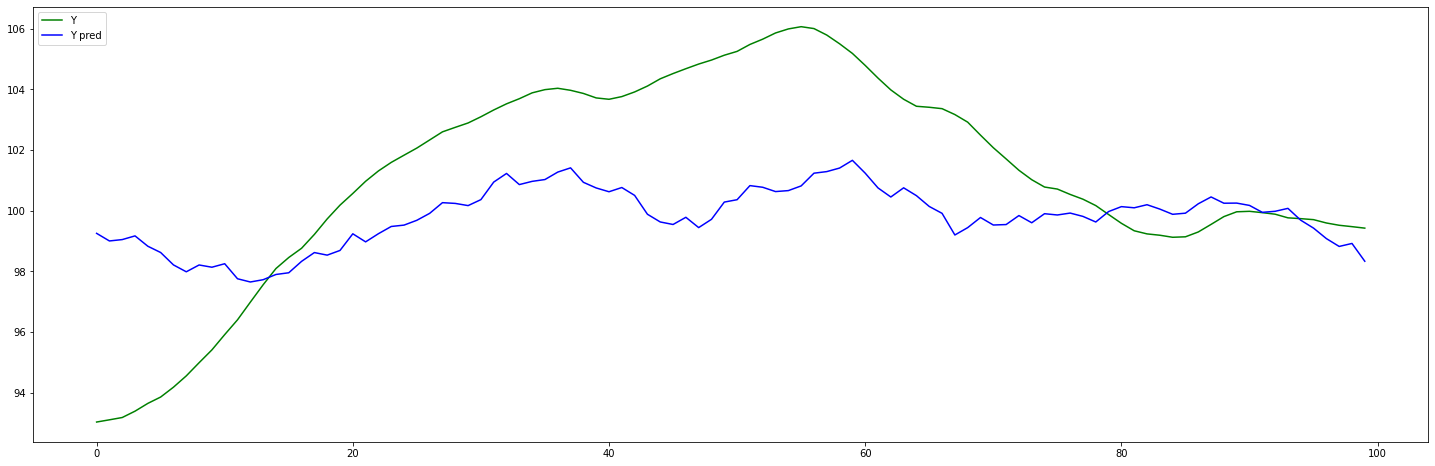

In [21]:
index = -1004

fig, ax_left = plt.subplots(1, figsize=(25,8))


ax_left.plot(list(range(len(y[index][0]))),y[index][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='Y')
ax_left.plot(list(range(len(predictions[index][0]))),savgol_filter(predictions[index][0]*df.Close_filtered.std()+df.Close_filtered.mean(), 25, 2,mode='nearest'),color='blue',label='Y pred')
ax_left.legend(loc="upper left")

# Denoising with KNN

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import pywt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
import statsmodels as sm


def lowpassfilter(signal, thresh = 0.63, wavelet="db5")-> np.array:
    """Perform a wavelet low pass filter on the data.

    Args:
        signal (numpy.array): The data to denoise.
        thresh (float, optional): The wavelet threshold to denoise data, higher threshold -> more denoise. Defaults to 0.63.
        wavelet (str, optional): Wavelet type 'sym5', 'coif5', 'bior2.4': . Defaults to "db5".

    Returns:
        numpy.array: Denoised data
    """
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    if len(signal) % 2==0:
        return reconstructed_signal
    else:
        return reconstructed_signal[1:]
    
    
    
def fft_denoiser(x, n_components=0.0005, to_real=True)-> np.array:
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return pd.Series(clean_data)


def polynomialRegression(data, order,auto_order=True)->np.array:
    """Perform a polynomial regression on an input

    Args:
        data (numpy.array): The signal to denoise.
        order (int): The polynomial degree.
        auto_order (bool, optional): Whether we want to find the best fitting order or if we want to apply regression the a specific degree. Defaults to True.

    Returns:
        np.array: The denoised signal
    """
    indexs_2 = np.array([i for i in range(len(data))])
    indexs_2 = np.reshape(indexs_2, newshape=(1,-1))[0]
    if auto_order==True:
        RMSEs = []
        for i in range(order):
            features = PolynomialFeatures(degree=i+1)
            x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
            
            model = LinearRegression().fit(x_train_transformed, data)

            train_pred = model.predict(x_train_transformed)
            rmse_poly_4_train = mean_squared_error(data, train_pred, squared = False)
            RMSEs.append(rmse_poly_4_train)

        features = PolynomialFeatures(degree=RMSEs.index(min(RMSEs))+1)
        
    else:
        features = PolynomialFeatures(order)

    x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
    model = LinearRegression().fit(x_train_transformed, data) 
    x_test_transformed = features.fit_transform(indexs_2.reshape(-1, 1))

    train_pred = model.predict(x_train_transformed)
    test_pred = model.predict(x_test_transformed)

    return test_pred


def filterData(data, method='dwt')->np.array:
    """function the filter a signal with a specific method.

    Args:
        data (np.array): The input signal to denoise.
        method (str): The filtering/denoising method. Default to 'dwt'.

    Returns:
        np.array: The filtered signal.
    """
    if method=='savgol':
        return savgol_filter(data, 19, 2,mode='wrap',deriv=0)
    elif method=='fft':
        return  fft_denoiser(data, 20)
    elif method=='poly':
        return  polynomialRegression(data, data,order=30)
    elif method=='dwt':
        return  lowpassfilter(data,thresh=0.1)
    elif method=='hpf':
        cycle, trend = sm.tsa.filters.hpfilter(data)
        return trend 

def computeLaggingLinearRegression(df, col="Close",window=15,filter_ceof:bool=True, filter_method:str='savgol',derivative:bool=True)->pd.DataFrame:
    """Compute a lagging moving regression on a column with a window.

    Args:
        df (pd.DataFrame): The dataframe containing features.
        col (str, optional): The column we apply Linear regression on. Defaults to "Close.
        window (int, optional): The window we apply linear regression on. Defaults to 15.

    Returns:
        pd.DataFrame: The entry DataFrame we another column called B_MLR_coefs
    """  
    def computeLinearRegression(x,y)->float:
        """Compute simple linear regression between 2 vectors x and y

        Args:
            x (np.array): x vector
            y (np.array): y vector

        Returns:
            float: The coefficient a corresponding to the linear regression y=ax+b.
        """
        model = LinearRegression().fit(x,y)
        return model.coef_[0]
    
    df['B_MLR_coefs'] = np.nan
    df['B_MLR_coefs'].iloc[:-window] = [computeLinearRegression(df.Timestamp.values[i:i+window].reshape(-1, 1), df[col].values[i:i+window]) for i in range(len(df)-window)] 
    df = df.dropna()
    if filter_ceof==True:
        df['B_MLR_coefs_filtered'] = filterData(df.B_MLR_coefs.values,filter_method)
        if derivative==True:
            df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff(3)
    else:
        if derivative==True:
            df['B_MLR_coefs_diff'] = df['B_MLR_coefs'].diff()
    return df.dropna()




# Technical indicators
from ta.momentum import stochrsi,rsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import volume_weighted_average_price, ease_of_movement


def addIndicators(df:pd.DataFrame,b_engulfings:bool=False, derivative:bool=False, double_derivative:bool=False,heikin_ashi:bool=False,chandelier_exit:bool=False) -> pd.DataFrame:
    """Apply indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The dataframe you want to add indicators on.
        b_engulfings (bool, optional): Add bearish and bullish engulfing indicators. Defaults to False.
        derivative (bool, optional): Add the first derivative of the Close price. Defaults to False.
        double_derivative (bool, optional): Add the second derivative of the Close price. Defaults to False.
        heikin_ashi (bool, optional): Add the heikin_ashi candle to the dataframe. Defaults to False.
        chandelier_exit (bool, optional): Add the CE signal short and long to the dataframe. Defaults to False.

    Returns:
        pd.DataFrame: The same dataframe with indicators
    """
    df['High_Low_diff'] = df.High-df.Low
    df['EMA20'] = ema_indicator(df.Close,20)
    df['EMA50'] = ema_indicator(df.Close,50)
    df['EMA100'] = ema_indicator(df.Close,100)
    df['EMA200'] = ema_indicator(df.Close,200)
    df['MACD'] = macd_diff(df.Close)
    df['Stoch_RSI'] = stochrsi(df.Close, 14, smooth1=3, smooth2=3)
    df['Vortex'] = (vortex_indicator_pos(df.High,df.Low,df.Close,20,fillna=True)-1)-(vortex_indicator_neg(df.High,df.Low,df.Close,20,fillna=True)-1)
    df['Bollinger_low'] = bollinger_hband(df.Close,20,fillna=True)
    df['Bollinger_high'] = bollinger_lband(df.Close,20,fillna=True)
    df['ADX'] = adx(df.High,df.Low,df.Close)
    df['ATR'] = adx(df.High,df.Low,df.Close,22)
    df['CCI'] = cci(df.High,df.Low,df.Close,14)
    df['OVB'] = (np.sign(df.Close.diff())*df.Volume).fillna(0).cumsum()
    df['OVB_EMA200'] = ema_indicator(df.OVB,200)
    trixLength = 9
    trixSignal = 21
    df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
    df['TRIX_PCT'] = df["TRIX"].pct_change()*100
    df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
    df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
    df['EVM'] = ease_of_movement(df.High,df.Low,df.Volume,14)
    if chandelier_exit==True:
        df['CE_long'] = np.nan
        df['CE_short'] = np.nan
        df['CE_long'].iloc[22:] = [df['High'].iloc[i-22:i].max()-df['ATR'].iloc[i]*3 for i in range(22,len(df))]
        df['CE_short'].iloc[22:] = [df['Low'].iloc[i-22:i].min()+df['ATR'].iloc[i]*3 for i in range(22,len(df))]
    if b_engulfings==True:   
        def isBearishCandleStick(candle) -> bool:
            """Check whether a candle is a bearish candle or not

            Args:
                candle (pd.Series): The current candle that contains OHLC

            Returns:
                bool: A boolean representing if the candle is bearish candle (True) or not (False)
            """
            return candle['Close']<candle['Open']

        def isBullishCandleStick(candle) -> bool:
            """Check whether a candle is a bullish candle or not

            Args:
                candle (pd.Series): The current candle that contains OHLC

            Returns:
                bool: A boolean representing if the candle is bullish candle (True) or not (False)
            """
            return candle['Close']>candle['Open']

        def isBullishEngulfing(previous_candle,current_candle) -> int:
            """A function that check for bullish engulfing pattern through candle stick

            Args:
                previous_candle (pd.Series): The previous candle that contains OHLC
                current_candle (pd.Series): The current candle that contains OHLC

            Returns:
                int: represent the pattern spotting : 1 bullish engulfing, 0 not.
            """
            return 1 if isBearishCandleStick(previous_candle) and isBullishCandleStick(current_candle) and previous_candle['Open']<current_candle['Close'] and previous_candle['Close']>current_candle['Open'] else 0
            
        def isBearishEngulfing(previous_candle,current_candle) -> int:
            """A function that check for bearish engulfing pattern through candle stick

            Args:
                previous_candle (pd.Series): The previous candle that contains OHLC
                current_candle (pd.Series): The current candle that contains OHLC

            Returns:
                int: represent the pattern spotting : 1 bearish engulfing, 0 not.
            """
            return 1 if isBullishCandleStick(previous_candle) and isBearishCandleStick(current_candle) and previous_candle['Close']<current_candle['Open'] and previous_candle['Open']>current_candle['Close'] else 0    
                
        df['Bullish_engulfing'] = np.nan
        df['Bullish_engulfing'].iloc[1:] = [isBullishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
        df['Bearish_engulfing'] = np.nan
        df['Bearish_engulfing'].iloc[1:] = [isBearishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
    if derivative==True:
        df['Slope'] = df.Close.diff()
    if double_derivative==True:
        df['Acceleration'] = df.Close.diff().diff()
    if heikin_ashi==True:
        df['HA_Close'] = (df.Open + df.High + df.Low + df.Close)/4
        ha_open = [(df.Open[0] + df.Close[0]) / 2]
        [ha_open.append((ha_open[i] + df.HA_Close.values[i]) / 2) for i in range(0, len(df)-1)]
        df['HA_Open'] = ha_open
        df['HA_High'] = df[['HA_Open', 'HA_Close', 'High']].max(axis=1)
        df['HA_Low'] = df[['HA_Open', 'HA_Close', 'Low']].min(axis=1)
    return df.dropna()

In [62]:
df = computeLaggingLinearRegression(df,'Close',20)
df.head()

,Open,High,Low,Close,Volume,Timestamp,Close_filtered,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff
Date,,,,,,,,,,
2020-10-15 08:00:00,49.000,49.496,48.610,49.031,1977.936,1602741600,47.472154,-0.000057,-0.000061,0.000045
2020-10-15 09:00:00,49.150,49.208,48.610,49.000,3338.552,1602745200,47.388616,-0.000055,-0.000055,0.000032
2020-10-15 10:00:00,48.901,49.446,48.000,48.654,2041.204,1602748800,47.327780,-0.000053,-0.000055,0.000018
2020-10-15 11:00:00,48.406,48.646,45.681,46.121,6265.761,1602752400,47.316187,-0.000060,-0.000058,0.000003
2020-10-15 12:00:00,46.200,47.017,44.514,44.668,8352.379,1602756000,47.288220,-0.000070,-0.000065,-0.000010


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [65]:
coef_scaler = MinMaxScaler((-1,1))
df['coef_norm'] = coef_scaler.fit_transform(df['B_MLR_coefs_filtered'].values.reshape(-1, 1))
df.head()

,Open,High,Low,Close,Volume,Timestamp,Close_filtered,B_MLR_coefs,B_MLR_coefs_filtered,B_MLR_coefs_filtered_diff,coef_norm
Date,,,,,,,,,,,
2020-10-15 08:00:00,49.000,49.496,48.610,49.031,1977.936,1602741600,47.472154,-0.000057,-0.000061,0.000045,0.216372
2020-10-15 09:00:00,49.150,49.208,48.610,49.000,3338.552,1602745200,47.388616,-0.000055,-0.000055,0.000032,0.218869
2020-10-15 10:00:00,48.901,49.446,48.000,48.654,2041.204,1602748800,47.327780,-0.000053,-0.000055,0.000018,0.219247
2020-10-15 11:00:00,48.406,48.646,45.681,46.121,6265.761,1602752400,47.316187,-0.000060,-0.000058,0.000003,0.217801
2020-10-15 12:00:00,46.200,47.017,44.514,44.668,8352.379,1602756000,47.288220,-0.000070,-0.000065,-0.000010,0.214595


In [80]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

clf =LinearRegression()
clf.fit(df.B_MLR_coefs.values.reshape(-1, 1), df.B_MLR_coefs_filtered)

LinearRegression()

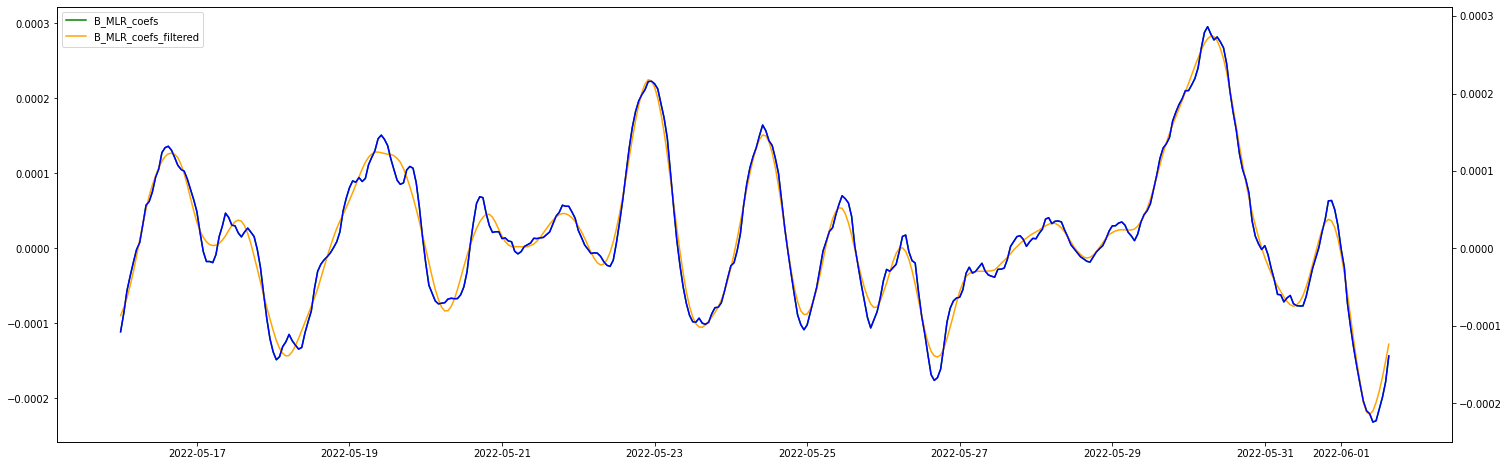

In [81]:
df['Close_pred'] = clf.predict(df.B_MLR_coefs.values.reshape(-1, 1))

window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df_see.B_MLR_coefs, color='green',label='B_MLR_coefs')
ax_left.plot(df_see.B_MLR_coefs_filtered, color='orange',label='B_MLR_coefs_filtered')
ax = ax_left.twinx()
ax.plot(df_see.Close_pred, color='blue',label='B_MLR_coefs denoised')
ax_left.legend(loc="upper left")

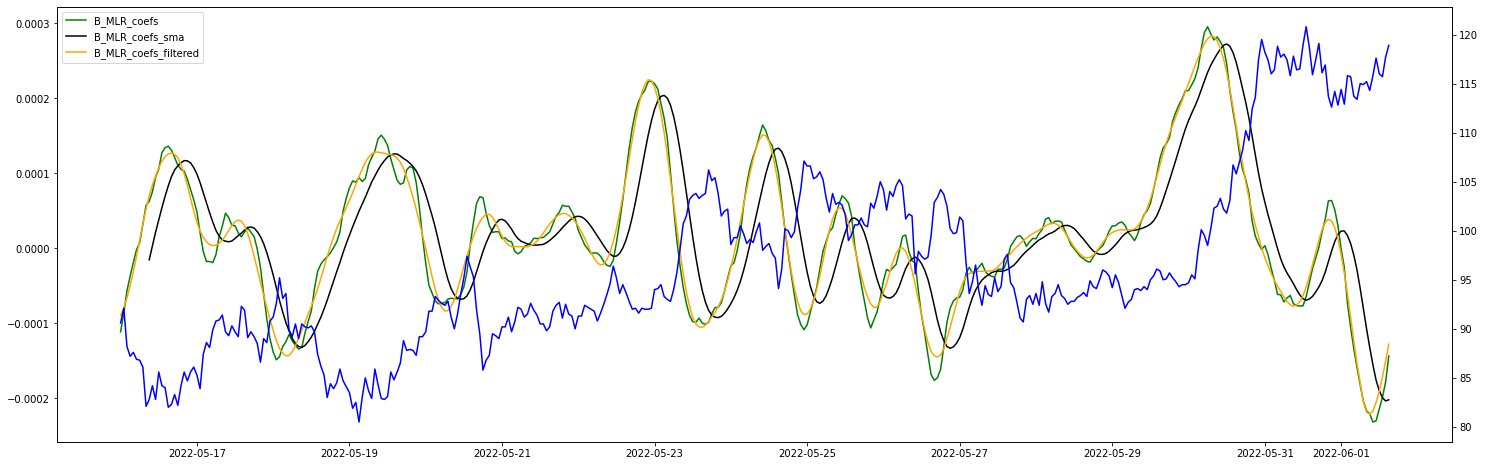

In [84]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(df.Timestamp.values, df.B_MLR_coefs.values, bc_type='natural')

df['Close_pred'] = cs(df.Timestamp.values.reshape(-1, 1))

window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df_see.B_MLR_coefs, color='green',label='B_MLR_coefs')
ax_left.plot(df_see.B_MLR_coefs.rolling(10).mean(), color='black',label='B_MLR_coefs_sma')
ax_left.plot(df_see.B_MLR_coefs_filtered, color='orange',label='B_MLR_coefs_filtered')
ax = ax_left.twinx()
ax.plot(df_see.Close, color='blue',label='Close')
ax_left.legend(loc="upper left")